# Solve stationary Stokes problem

In [9]:
%pylab inline
import scipy

from pyiga import bspline, assemble, geometry, vis

Populating the interactive namespace from numpy and matplotlib


In [10]:
# define geometry
geo = geometry.quarter_annulus()

# define isogeometric Taylor-Hood discretization space
p = 3     # spline degree of velocity space
n_el = (50, 25)   # number of elements in y/x direction

# velocity space: degree p,   continuity p-2
# pressure space: degree p-1, continuity p-2
kvs_u = tuple(bspline.make_knots(p,   0.0, 1.0, n, mult=2) for n in n_el)
kvs_p = tuple(bspline.make_knots(p-1, 0.0, 1.0, n, mult=1) for n in n_el)

m_u = tuple(kv.numdofs for kv in kvs_u)
m_p = tuple(kv.numdofs for kv in kvs_p)

In [12]:
# assemble the Stokes system matrix
A_grad = assemble.assemble('inner(grad(u), grad(v)) * dx', kvs_u, bfuns=[('u',2), ('v',2)], geo=geo)
A_div  = assemble.assemble('div(u) * p * dx', (kvs_u, kvs_p), bfuns=[('u',2,0), ('p',1,1)], geo=geo)

A_stokes = scipy.sparse.bmat(
    [[A_grad, A_div.T],
     [A_div,  None]], format='csr')

In [4]:
# define Dirichlet boundary conditions for lid-driven cavity problem
def g_lid(x, y):  return (x*y*-y, x*y*x)
def g_zero(x, y): return (0.0, 0.0)

bcs = assemble.compute_dirichlet_bcs(kvs_u, geo,
        [('bottom', g_zero), ('top', g_zero), ('left', g_lid), ('right', g_zero)])

# fix pressure to 0 at an arbitrary (the first) pressure dof
N = np.prod(tuple(kv.numdofs for kv in kvs_u))
bcs = (np.append(bcs[0], 2*N), np.append(bcs[1], 0.0))

In [5]:
# solve Stokes system with the given boundary conditions and 0 right-hand side
LS = assemble.RestrictedLinearSystem(A_stokes, 0.0, bcs)
u = scipy.sparse.linalg.spsolve(LS.A, LS.b)
u = LS.complete(u)

In [6]:
# split the solution into its components (velocity and pressure)
u1 = u[:N].reshape(m_u)
u2 = u[N:2*N].reshape(m_u)
U = np.stack((u1,u2), axis=-1)
prs = u[2*N:].reshape(m_p)

velocity = geometry.BSplineFunc(kvs_u, U)
pressure = geometry.BSplineFunc(kvs_p, prs)

In [7]:
# evaluate velocity and pressure over a grid in the parameter domain
xgrid = linspace(0, 1, 200)
xygrid = (xgrid, xgrid)

G = geo.grid_eval(xygrid)
vel = velocity.grid_eval(xygrid)
pre = pressure.grid_eval(xygrid)

In [8]:
# interpolate velocity in [0,2] x [0,2] (physical coordinates) for streamplot
pgridx, pgridy = meshgrid(linspace(0,2,200), linspace(0,2,200), indexing='xy', sparse=True)
pvel = scipy.interpolate.griddata(G.reshape((-1,2)), vel.reshape((-1,2)), (pgridx,pgridy), method='cubic')

# mask out the inner radius
pvel[(pgridx**2 + pgridy**2) <= 1] = nan

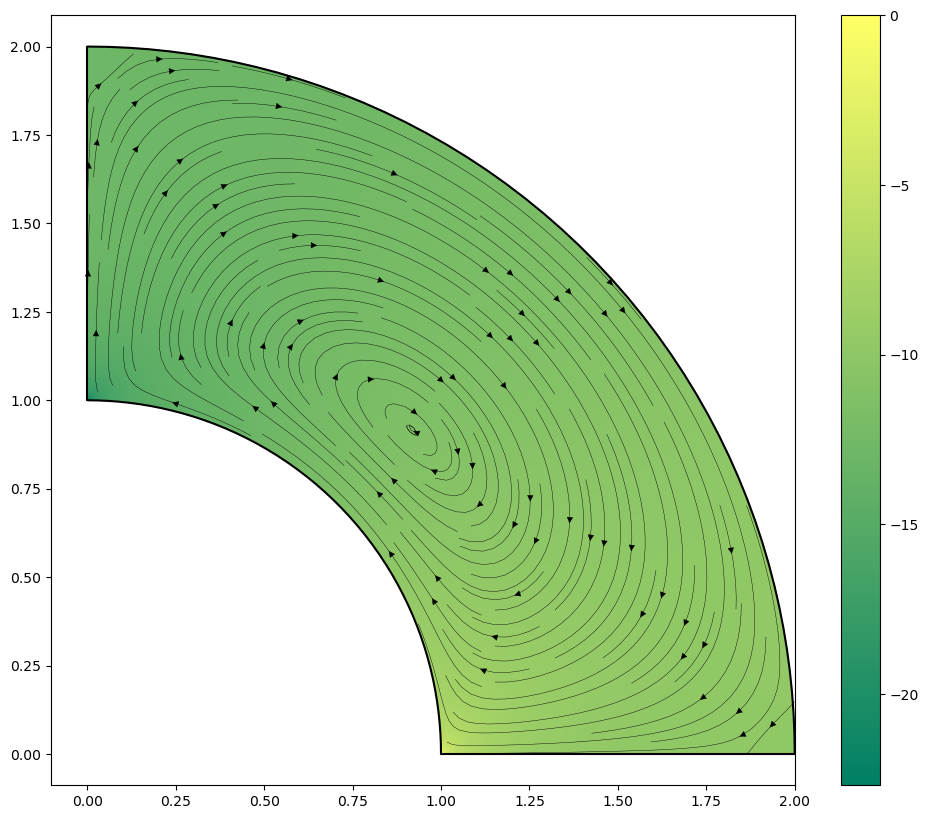

In [9]:
# plot velocity and pressure
figsize(12,10)

vis.plot_geo(geo, grid=2)
pcolormesh(G[...,0], G[...,1], pre, cmap='summer', shading='gouraud');
colorbar();

streamplot(pgridx[0,:], pgridy[:,0], pvel[...,0], pvel[...,1],
           density=2, color='black', linewidth=0.3)

axis('equal');